In [197]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy
import matplotlib.pyplot as plt
import utils.dlc_practical_prologue as prologue

import multiprocessing

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


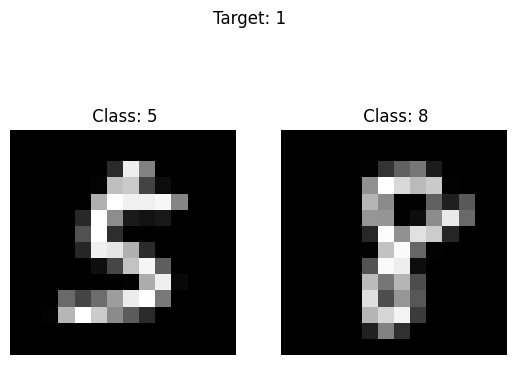

Train input shapetorch.Size([1000, 2, 14, 14])
Train target shapetorch.Size([1000])
Train classes shapetorch.Size([1000, 2])
---
Test input shape torch.Size([1000, 2, 14, 14])
Test target shape torch.Size([1000])
Test classes shape torch.Size([1000, 2])


In [198]:
from torch.utils.data import Dataset

from torch.utils.data import TensorDataset

BATCH_SIZE = 2

transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.Lambda(lambda x: x.div(255))]
)

train_input, train_target, train_classes,\
    test_input, test_target, test_classes = prologue.generate_pair_sets(
        1000, transform=transform)
    
# train_input = transform(train_input)
# test_input = transform(test_input)

trainset = TensorDataset(train_input, train_target)
testset = TensorDataset(test_input, test_target)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers= 1)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers= 1)

# target: 1 if digit 1 <= digit 2, 
#         0 otherwise

# Plotting the first 5 pairs of images
for i in range(1):
    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.imshow(train_input[i, j].view(14, 14), cmap='gray')
        # plot the target and its class in the title
        plt.suptitle(f"Target: {train_target[i]}")
        plt.title(f' Class: {train_classes[i, j]}')
        plt.axis('off')
    plt.show()

# print the shapes of the tensors
print(f"Train input shape{train_input.shape}")
print(f"Train target shape{train_target.shape}")
print(f"Train classes shape{train_classes.shape}")
print('---')
print(f"Test input shape {test_input.shape}")
print(f"Test target shape {test_target.shape}")
print(f"Test classes shape {test_classes.shape}")


## Examine data format and normalize

In [199]:
print(train_input[0,1].shape)
print(train_input[0,1].dtype)
print(train_input[0,1].max())
print(train_input[0,1].min())

torch.Size([14, 14])
torch.float32
tensor(0.9824)
tensor(0.)


### Baseline

In [200]:
print(torch.mean(train_target.float()))
print(torch.mean(test_target.float()))

tensor(0.5620)
tensor(0.5500)


In [201]:
baseline_target_pred = torch.ones_like(train_target)

# compute accuracy of the baseline and the test target
acc = 100 * (baseline_target_pred == test_target).sum().item() / test_target.shape[0]
print(f"Baseline accuracy: {acc:.2f}%")

Baseline accuracy: 55.00%


### Convnet

TODO now:

1. figure out parameters for cnn layers

    a. Figure out input (w/ 2 images)
    
    b. Debug conv and pool parameters

2. Optimizer

In [202]:
torch.cuda.is_available()

False

In [203]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, (3, 3))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, (3,3))
        self.fc1 = nn.Linear(32*4*4, 200)
        self.fc2 = nn.Linear(200, 1)
        # self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # flatten features

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=0) # return a probability
        # x = self.fc3(x)
        return x

net = Net()

In [204]:
import torch.optim as optim

criterion = nn.BCELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5)
optimizer = optim.Adam(net.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net.to(device)

cpu


Net(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=1, bias=True)
)

In [205]:
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        ## -- ! code required  
        
        inputs, labels = data
        # Concatenate both images side-by-side
        # left, right = inputs[:, 0], inputs[:, 1]
        # inputs = torch.cat((left, right), 2)
        # inputs = torch.unsqueeze(inputs, 1)
        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()   # zero the gradient buffers
        outputs = net(inputs)
        # print(outputs)
        # print(labels.reshape(-1, 1).type_as(outputs))
        loss = criterion(outputs, labels.reshape(-1, 1).type_as(outputs))
        # print(loss)
        loss.backward()
        optimizer.step()


        # print statistics

        running_loss += loss.item()
        if i % 10 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % 
                (epoch + 1, i + 1, running_loss / (1000/trainloader.batch_size)), end='\r')
            running_loss = 0.0

print('Finished Training')

Finished Training 0.010


In [206]:
def test_accuracy(net, testloader):

    acc = 0
    for i, data in enumerate(testloader, 0):
        
        inputs, labels = data

        # Concatenate both images side-by-side
        # left, right = inputs[:, 0], inputs[:, 1]
        # inputs = torch.cat((left, right), 2)
        # inputs = torch.unsqueeze(inputs, 1)
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs, labels = inputs.to(device), labels.to(device)
    
        outputs = net(inputs)
        equality = (labels.reshape(-1, 1) == outputs.round().to(torch.int))
        acc += equality.to(torch.float).mean()

    return acc.item() / (i+1)

acc = test_accuracy(net, testloader)
print(f'Accuracy of the network on the {(i+1)*testloader.batch_size} test images: {100*acc:.1f} %')

Accuracy of the network on the 1000 test images: 71.8 %


In [207]:
from torchsummary import summary
model_view = Net()
summary(model_view,(2,14,14))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 12, 12]          304
├─MaxPool2d: 1-2                         [-1, 16, 6, 6]            --
├─Conv2d: 1-3                            [-1, 32, 4, 4]            4,640
├─Linear: 1-4                            [-1, 200]                 102,600
├─Linear: 1-5                            [-1, 1]                   201
Total params: 107,745
Trainable params: 107,745
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.41
Estimated Total Size (MB): 0.44


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 12, 12]          304
├─MaxPool2d: 1-2                         [-1, 16, 6, 6]            --
├─Conv2d: 1-3                            [-1, 32, 4, 4]            4,640
├─Linear: 1-4                            [-1, 200]                 102,600
├─Linear: 1-5                            [-1, 1]                   201
Total params: 107,745
Trainable params: 107,745
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.41
Estimated Total Size (MB): 0.44

### model saving

In [208]:
# save model parameters
torch.save(net.state_dict(), './Models/cnn_3.pt')

In [209]:
# load model parameters
model1 = Net()
model1.load_state_dict(torch.load('./Models/cnn_3.pt'))
model1.eval()

Net(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=1, bias=True)
)